In [19]:
#Importações
import numpy as np
import numpy.random as npr
from sklearn import datasets
import pandas as pd
import copy
import matplotlib.pyplot as plt; plt.rcParams['figure.figsize'] = (15,8)
import seaborn as sns; sns.set(color_codes=True)
import csv
import math

In [20]:
#Individuo
class Individuo():  
    
    gene            = []    #Cromossomos (Aqui é X1 e X2)
    fitness         = 0.0   #Pontuação do Individuo
    #---------------
    maxGeneValue    = 5.12   #Maior valor para Desnormalização
    minGeneValue    = -5.12  #Menor valor para Desnormalização
    #---------------
    maxValueNorm    = 1.0   #Maior valor para Normalizar
    minValueNorm    = 0.0   #Menor valor para Normalizar
    maxChromosome   = 2     #Quantidade maxima de cromossomos

    #Inicializa os atributos do Individuo
    def __init__(self):
        self.createGenes()
        self.fitnessFuncRastrigin()

    #Usando uma distribuição uniforme gere uma população de sequências de números reais normalizados entre 0 a 1.
    def createGenes(self):
        self.gene = np.random.uniform(self.minValueNorm, self.maxValueNorm, self.maxChromosome)
        self.denormalizationGenes()
    
    #Desnormalização os valores dos genes
    def denormalizationGenes(self):
        for i in range(0, self.maxChromosome-1):
            # Equação 1 (Desnormaliza de 0 e 1 para a faixa dos valores do targetGene)
            # x = min + (max-min) * value 
            self.gene[i] = self.minGeneValue + (self.maxGeneValue-self.minGeneValue) * self.gene[i]
   
    #F5 Rastrigin's function | multimodal, symmetric, separable
    def fitnessFuncRastrigin(self):
        indDecod = self.gene
        self.fitness = 10*len(indDecod)
        for i in range(len(indDecod)):
            self.fitness += indDecod[i]**2 - (10*math.cos(2*math.pi*indDecod[i]))    

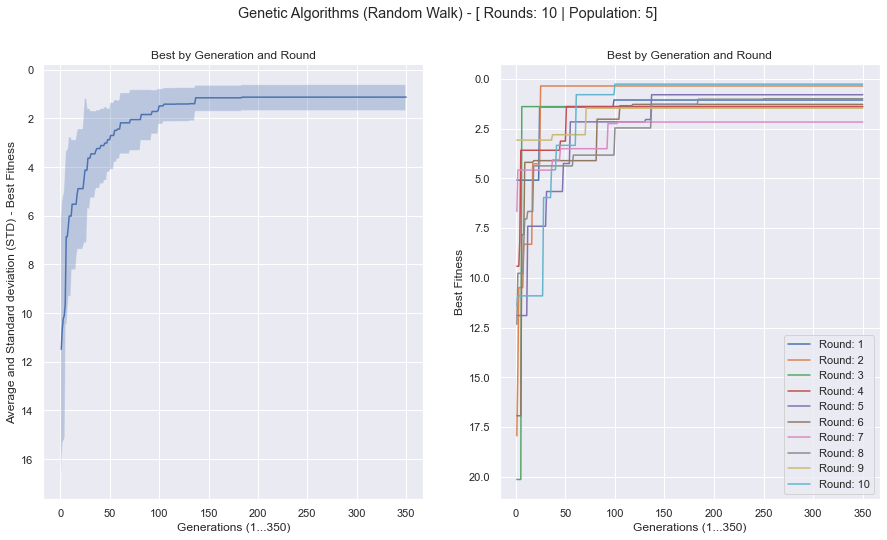

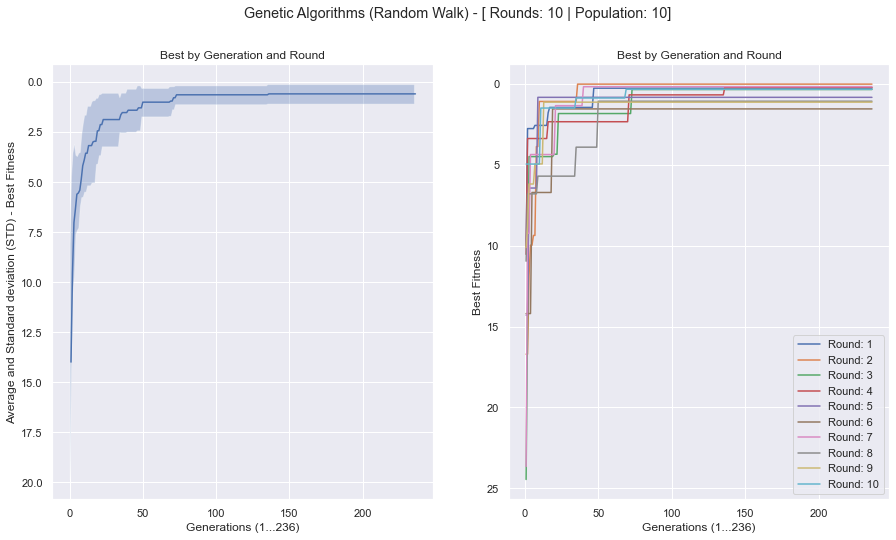

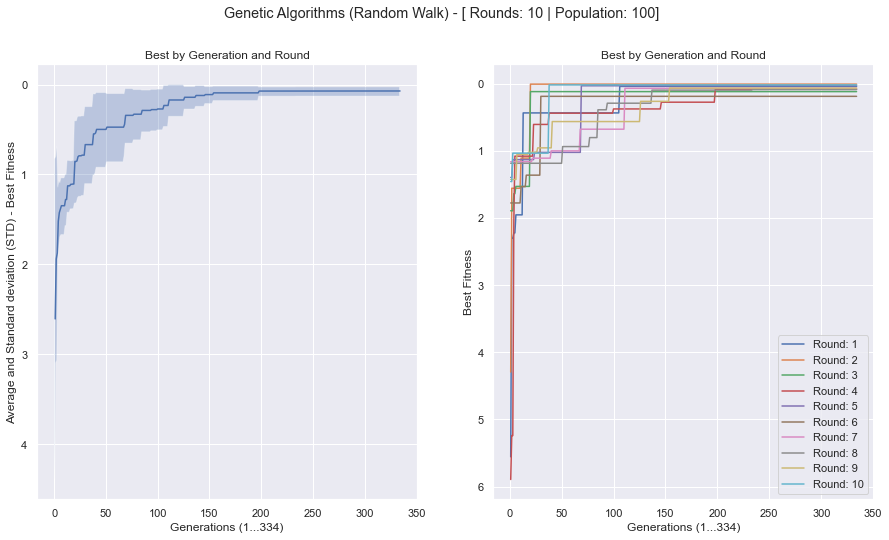

In [21]:
#Populacao
class Populacao():
    
    #---------
    population              =   []      #Conjunto de Individuos de uma geração
    sizePopulation          =   100    #Total de individuos na população
    bestIndGeneration       =   []      #Melhor individuo de cada Geração
    bestIndividuo           =   None    #Guarda o ULTIMO melhor individuo da geração
    countNoEvolution        =   0       #Contador de fitness que não evolui (count_stagnation)
    limitNoEvolution        =   100     #Limite maximo de fitness que não evolui (Limite K)
    evolution               =   0.01    #Se por K gerações a qualidade da solução ficou abaixo de um delta (= 0.01, por exemplo), então o algoritmo alcançou sua condição de parada.
    #---------
    listGenerations         =   []      #Matriz de "bestIndGeneration" (Guarda os dados gerais da geração e melhores individuos)
    meanBestFitness         =   []      #Média das Gerações guardadas em "listGenerations"
    stdBestFitness          =   []      #Desvio Padrão das Gerações guardadas em "listGenerations"
    rounds                  =   10      #Maximo de Rodadas (1 Rodada tem N gerações)    
    #----------
    numMaxGenerations       =   []      #só guarda os numeros das gerações 0 a N para o plot no grafico

    def runPopulation(self, maxRounds, sizePop):
        self.sizePopulation         = sizePop
        self.rounds                 = maxRounds
        self.listGenerations        =  []
        self.meanBestFitness        =  []
        self.stdBestFitness         =  []
        self.numMaxGenerations      =  []

       #N Rodadas.
        for i in range(0, self.rounds): 
            self.population         =   []
            self.bestIndGeneration  =   []
            self.bestIndividuo      =   None
            self.countNoEvolution   =   0

            #N Gerações até que o maximo de gerações sem mudança seja atingido.
            while(True):
                #-------------------
                #Cria a população
                self.createPopulation()
                
                #Ordena do Menor pro Maior
                self.orderPopByFitness()
                #-------------------
                
                currentBestIndividuo = self.population[0]

                #Gerencia aquantidade de gerações sem mudanças.
                if (self.bestIndividuo != None):
                    var_fitness = abs(currentBestIndividuo.fitness-self.bestIndividuo.fitness)/self.bestIndividuo.fitness
                    if var_fitness < self.evolution:
                        self.countNoEvolution += 1
                    else:
                        self.countNoEvolution = 0

                #Pega o melhor individuo e Guarda pra geração seguinte
                self.bestIndividuo = currentBestIndividuo

                #Garante 50% dos melhores individuos da população anterior na nova população (Dividepor 2 retornando um int "//")
                self.population = self.population[:len(self.population)//2]
                if (self.bestIndividuo != None): 
                    self.bestIndGeneration.append(self.bestIndividuo)
                
                #Verifica se chegamos na ultima geração
                if self.countNoEvolution == self.limitNoEvolution:
                    break

            #Guarda esta geração de melhores individuos na lista.
            self.listGenerations.append(self.bestIndGeneration)
        
        self.normalizaArrays(self.listGenerations)
        self.meanStdGenerations()

    #Deixa todas as lista do mesmo tamanho (Repetindo o ultimo individuo), 
    #em uma matriz multidimensional ou lista que guarda outras listas
    def normalizaArrays(self, matriz):
        maior = 0
        #Descobre qual o comprimento maximo da lista
        for array in matriz:
            if (len(array) > maior):
                maior = len(array)        
        #Repete o ultimo elemento até atingir o tamanho correto.
        for array in matriz:
            while(len(array) < maior):
                array.append(array[-1])
        return matriz

    #Calcula a média e desvio padrão das gerações
    def meanStdGenerations(self):
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            fits = []
            for ind in listInd: #[2,2]
                fits.append(ind.fitness)
            meanFitsGen = np.mean(fits)
            self.meanBestFitness.append(round(meanFitsGen,3)) 
            self.stdBestFitness.append(round(np.std(fits), 3))

        for i in range(0, len(self.meanBestFitness)):
            self.numMaxGenerations.append(i+1)

    #Cria a população    
    def createPopulation(self):
        size = self.sizePopulation - len(self.population)
        for i in range(size):
            novoIndividuo = Individuo()
            self.population.append(novoIndividuo)

    #Ordena os individuos da população pelo seu fitness
    def orderPopByFitness(self):
        self.population.sort(key=lambda ind: ind.fitness, reverse=False) 

    def bestFitnessByRound(self, round):
        teste = []
        for i in self.listGenerations[round]:
            teste.append(i.fitness)
        return teste

    def bestFitnessByRoundAndGen(self):
        listRoundFits = []
        fieldNames = []
        for listInd in zip(*self.listGenerations): #[ [ind1, ind2] [ind3, ind4, ind5] ]
            listFitsInd = []
            for ind in listInd: #[2,2]
                listFitsInd.append(ind.fitness)
            listRoundFits.append(listFitsInd)
        
        for i in range(0, self.rounds):
            fieldNames.append('Round ' + str(i+1))
        
        #Adiciona a lista de nomes no inicio da nova lista e embaixo a lista já existente
        #Ambos os comandos funcionam
        listRoundFits.insert(0,fieldNames) #newListResult = [fieldNames, *listRoundFits]
        return listRoundFits #return newListResult


    def stdFitnessLow(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]-self.stdBestFitness[i],3))
        return result        

    def stdFitnessHigh(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append(round(self.meanBestFitness[i]+self.stdBestFitness[i], 3))
        return result        

    def stdCountGen(self):
        result = []
        for i in range(0, len(self.meanBestFitness)):
            result.append("Generation " + str(i+1))
        return result 

    def showGraphMeanStdBestFitness(self):
        fig, (plotBestFitGenMeanStd, plotBestFitGen) = plt.subplots(1,2)
        fig.suptitle('Genetic Algorithms (Random Walk) - ['+ ' Rounds: '+str(self.rounds) +' | Population: '+ str(self.sizePopulation)+']')
        
        plotBestFitGenMeanStd.plot(self.numMaxGenerations, self.meanBestFitness, label = "Media e Desvio Padrão")
        plotBestFitGenMeanStd.fill_between(range(len(self.meanBestFitness)),self.stdFitnessLow(),self.stdFitnessHigh(),alpha=.3)
        
        for i in range(0, self.rounds):
            plotBestFitGen.plot(self.numMaxGenerations, self.bestFitnessByRound(i), label = "Round: " + str(i+1))    
        
        plotBestFitGen.set_title('Best by Generation and Round')
        plotBestFitGen.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGen.set_ylabel('Best Fitness')
        plotBestFitGen.invert_yaxis()

        plotBestFitGenMeanStd.set_title('Best by Generation and Round')
        plotBestFitGenMeanStd.set_xlabel('Generations (1...'+str(len(self.numMaxGenerations))+')')
        plotBestFitGenMeanStd.set_ylabel('Average and Standard deviation (STD) - Best Fitness')
        plotBestFitGenMeanStd.invert_yaxis()

        prefixFile = "R_"+str(self.rounds) +"P_"+ str(self.sizePopulation)+"_"

        plt.legend()                                    
        plt.show()        
        fig.savefig(prefixFile+'resultPlot.png', dpi=300)  

        # Salva em CSV (Separado por ";") indicando que os valores são Strings (%s)
        np.savetxt(prefixFile+"dataBestFitGenByRound.csv", self.bestFitnessByRoundAndGen(), delimiter =";", fmt ='%s')
        np.savetxt(prefixFile+"dataMeanStdBestFitGen.csv", self.meanStdBestFitGen(), delimiter =";", fmt ='%s')

    def meanStdBestFitGen(self):
        result = []
        result.append(["Std(Low)", *self.stdFitnessLow()])
        result.append(["Mean", *self.meanBestFitness])
        result.append(["Std(High)", *self.stdFitnessHigh()])
        result.insert(0, [" --- ", *self.stdCountGen()])
        return result

pop = Populacao()
#Executa o algoritmo com N Rodadas e M de População
pop.runPopulation(10, 5)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 10)
pop.showGraphMeanStdBestFitness()
pop.runPopulation(10, 100)
pop.showGraphMeanStdBestFitness()